</center><img src="https://www.inovex.de/wp-content/uploads/2019/02/Price-Prediction-in-Online-Car-Marketplaces-1500x880.png" style="width: 200px;"/></center>

## Прогнозирование стоимости автомобиля по характеристикам

> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

The collected data "merged.csv" was created using the ADDPATH to github noteboook

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression
import numpy as np
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
import xgboost as xgb
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


/home/anara/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:123: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy        : 1.18.3


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
# DIR_TRAIN  = '../input/collected-data/' 
# DIR_TEST   = '../input/sf-dst-car-price-prediction/'
DIR_TRAIN  = 'for_train/' 
DIR_TEST   = 'for_test/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
# !ls '../input'

In [8]:
train = pd.read_csv(DIR_TRAIN +'merged.csv', sep=';', lineterminator='\n')
# train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head(5)

,Unnamed: 0,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,...,Владение,ПТС,Привод,Руль,Состояние,Таможня,Region,Taxes,Views,Price
0,0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,{'id': '0'},Читайте пожалуйста внимательно. Чистокровная Ч...,1.6,101,"{'condition': True, 'hatch': True}",...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,2525.0,137.0,370000.0
1,1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,{'id': '0'},ЗдравствуйтеПродаю автомобиль Состояние хороше...,1.9,110,{},...,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,NaN,2750.0,5.0,220000.0
2,2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,{'id': '0'},ПТС оригинал. Ходовая в норме. Мотор на отличн...,1.4,60,"{'esp': True, 'airbag-driver': True, 'aux': Tr...",...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,2040.0,121.0,390000.0
3,3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia_r...,серый,"{'id': '5011515', 'name': 'RS', 'available_opt...",2 Владелец Документы Оригинал Комплект Ключей ...,2.0,200,"{'cruise-control': True, 'esp': True, 'airbag-...",...,10 лет и 1 месяц,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"Привольная улица, 65/32",10000.0,185.0,960000.0
4,4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серый,{'id': '0'},"Продаю а/м в хорошем техническом состоянии, дл...",1.9,105,{},...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,3570.0,126.0,770000.0


In [10]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [11]:
train.columns

Index(['Unnamed: 0', 'bodyType', 'brand', 'car_url', 'color',
       'complectation_dict', 'description', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_info', 'model_name', 'name', 'numberOfDoors',
       'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id',
       'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
       'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'Region', 'Taxes', 'Views', 'Price'],
      dtype='object')

In [12]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

## Data Preprocessing

In [13]:

def calculate_tax(power, own_month):
    
    if 0<=power<=100: 
        rate = 12
    elif 100.01<power<=125:
        rate = 25
    elif 125.01<power<=150:
        rate = 35
    elif 150.01<power<=175:
        rate = 45
    elif 175.01<power<=200:
        rate = 50
    elif 200.01<power<=225:
        rate = 65
    elif 225.01<power<=250:
        rate = 75
    elif power>250:
        rate = 150
    else:
        rate = None
    
    if not np.isnan(own_month):
        tax = power * rate * (own_month/12)
    else: 
        tax = power * rate * 1.1
     
    return round(tax)

In [14]:

def convert_ownership_duration_to_month(txt):
    year_month_own = [int(s) for s in txt.split() if s.isdigit()] # txt = "11 лет и 3 месяца"
    month = year_month_own[0] * 12 + year_month_own[1]
    return month


### Train data set

In [15]:
train.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
# check NaNs
train.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict          0
description               525
engineDisplacement          0
enginePower                 0
equipment_dict              0
fuelType                    0
image                   26598
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency              53
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   1
Владение                18039
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
Region                   9365
Taxes     

In [17]:
# drop nans in Price and PriceCurrency 
train = train.dropna(subset=['Price', 'priceCurrency'])


We can calculate taxes using the formulae from https://www.nalog.gov.ru/rn77/service/calc_transport/
![alt text](ff.png "Title" )
![alt text](tt.png "Title" )


- Если легковой автомобиль стоит от 3 миллионов до 5 миллионов рублей включительно и с года выпуска прошло не более 3 лет, то при исчислении налога применяется коэффициент 1,1. 
- Коэффициент 2 применяется в отношении легковых автомобилей стоимостью от 5 миллионов до 10 миллионов рублей включительно, если с года их выпуска прошло не более 5 лет;
- Самый большой коэффициент — 3, применяется в отношении легковых автомобилей стоимостью от 10 миллионов до 15 миллионов рублей включительно, если с года их выпуска прошло не более 10 лет, а также в отношении легковых автомобилей стоимостью от 15 миллионов рублей, с года выпуска которых прошло не более 20 лет.

In [18]:
nan_taxes = train[train['Taxes'].isna()]

In [19]:
nan_taxes['Владение'].dropna().apply(lambda x: convert_ownership_duration_to_month(x))


21371    105
21515    101
25732    135
Name: Владение, dtype: int64

In [20]:
nan_taxes.loc[21371, 'Владение'] = 105 
nan_taxes.loc[21515, 'Владение'] = 101 
nan_taxes.loc[25732, 'Владение'] = 135 

/home/anara/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [21]:
for index, row in nan_taxes.iterrows():
    train.loc[index, 'Taxes'] = calculate_tax(row['enginePower'], row['Владение'])

In [22]:
train.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict          0
description               521
engineDisplacement          0
enginePower                 0
equipment_dict              0
fuelType                    0
image                   26545
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   1
Владение                18001
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
Region                   9330
Taxes     

In [23]:
train['Views'] = train['Views'].fillna(value=train['Views'].mean())

I assume that Region won't bring any useful information, because some clients had written their own address instead of a region of the city, thus I would drop it

In [24]:
train.drop(columns=['Region'], inplace=True)

### Merge parsed train and given test sets

In [25]:
train.columns.symmetric_difference(test.columns)

Index(['Price', 'Taxes', 'Views'], dtype='object')

In [26]:
# add columns to test set
test['Price'] = 0
test['Taxes'] = 0
test['Views'] = 0

In [27]:
train['train'] = 1
test['train'] = 0

In [28]:
df = pd.concat([test, train], join='inner', ignore_index=True)
df.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,Владение,ПТС,Привод,Руль,Состояние,Таможня,Price,Taxes,Views,train
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0.0,0.0,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0.0,0.0,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0.0,0.0,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0.0,0.0,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0.0,0.0,0


### Cleaning merged data

In [29]:
# rename columns
df = df.rename(columns={'Владельцы': 'owners', 'Владение': 'ownership_duration', 'ПТС': 'passport', 
                        'Привод': 'drive', 'Руль': 'wheel', 'Состояние': 'condition', 'Таможня':'customs'})
                            

In [30]:
df.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'owners', 'ownership_duration',
       'passport', 'drive', 'wheel', 'condition', 'customs', 'Price', 'Taxes',
       'Views', 'train'],
      dtype='object')

In [31]:
cols_to_drop = []

- <b>bodytype<b>


In [32]:
df['bodyType'].unique()


array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [33]:
df.bodyType = df.bodyType.apply(lambda x: x.strip().split()[0] if isinstance(x, str) else x)

In [34]:
df.bodyType.unique()

array(['лифтбек', 'внедорожник', 'хэтчбек', 'седан', 'компактвэн',
       'универсал', 'пикап', 'купе', 'кабриолет', 'минивэн', 'родстер',
       'микровэн', 'купе-хардтоп', 'фастбек', 'тарга', 'лимузин',
       'седан-хардтоп', 'фургон'], dtype=object)

- <b>color<b>

In [35]:
df['color'].unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый'],
      dtype=object)

- <b>description<b>

In [36]:
df['description'] = df['description'].fillna('no info')

In [37]:
df['descr_words_count'] = df.description.apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df['descr_words_count'].replace([np.inf, -np.inf], 0, inplace=True)

In [38]:
cols_to_drop.append('description')

- <b>fuelType<b>

In [39]:
df['fuelType'].value_counts()

бензин                             28601
Бензин                             17755
Дизель                              7681
дизель                              5800
Гибрид                               701
гибрид                               223
Бензингазобаллонноеоборудование      176
Электро                               95
Газ                                   76
Дизельгазобаллонноеоборудование       57
электро                               55
газ                                    7
Газгазобаллонноеоборудование           2
Гибридгазобаллонноеоборудование        2
Name: fuelType, dtype: int64

In [40]:
df['fuelType'] = df['fuelType'].apply(lambda x: x.lower().strip())

In [41]:
df['fuelType'] = df['fuelType'].replace({'газгазобаллонноеоборудование':'газ'})

In [42]:
df['fuelType'].value_counts()

бензин                             46356
дизель                             13481
гибрид                               924
бензингазобаллонноеоборудование      176
электро                              150
газ                                   85
дизельгазобаллонноеоборудование       57
гибридгазобаллонноеоборудование        2
Name: fuelType, dtype: int64

- <b>engineDisplacement<b>

In [43]:
df['engineDisplacement'].unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '1.6', '1.9', '1.4', '2.0', '1.2', '1.8', '1.0', '1.5',
       '1.3', '3.6', '2.5', '2.8', '2.3', '2.7', '2.4', '4.2', '4.0',
       '3.0', '4.1', '2.2', '3.1', '3.2', '2.9', '646..', '2.6', '6.0',
       '503..', '5.9', '6.3', '408..', '313..', '3.9', '5.0', '5.2',
       '299..', '2.1', '3.3', '3.7', '1.7', '3.5', '0.7', '4.

When an auto is electric the website shows information of engineDisplacement and enginePower other way around, so I will firstly reassign the values of these 2 columns only for electro cars. Additionally I will set the values of engineDisplacement for electro cars to 0 and add a separate column power_kvt.

In [44]:
df.loc[df['fuelType'] == 'электро', 'engineDisplacement'] = 0

In [45]:
# create new column power_kvt
df['power_kvt'] = 0

In [46]:
for idx, row in df.iterrows():
    if row['fuelType'] == 'электро':
        df.loc[idx, 'enginePower'] = ast.literal_eval(row.super_gen)['power']
        df.loc[idx, 'power_kvt'] = ast.literal_eval(row.super_gen)['power_kvt'] # for electro cars only
    

In [47]:
df['engineDisplacement'].unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', 0, '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '1.6', '1.9', '1.4', '2.0', '1.2', '1.8', '1.0', '1.5',
       '1.3', '3.6', '2.5', '2.8', '2.3', '2.7', '2.4', '4.2', '4.0',
       '3.0', '4.1', '2.2', '3.1', '3.2', '2.9', '2.6', '6.0', '5.9',
       '6.3', '3.9', '5.0', '5.2', '2.1', '3.3', '3.7', '1.7', '3.5',
       '0.7', '4.4', '4.6', '5.4', '6.6', '4.8', '3.4', '4.9', '5.6

In [48]:
 df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: str(x).replace('LTR', '').strip())

In [49]:
df['engineDisplacement'] =  df['engineDisplacement'].astype(float)

- <b>enginePower<b>

In [50]:
df['enginePower'] = df['enginePower'].apply(lambda x: str(x).replace('N12', '').strip())

In [51]:
df['enginePower'] =  df['enginePower'].astype(float)

- <b>image<b>

In [52]:
cols_to_drop.append('image')

- <b>model_info<b>

In [53]:
cols_to_drop.append('model_info')

- <b>name<b>

In [54]:
cols_to_drop.append('name')

- <b>numberOfDoors<b>

In [55]:
df['numberOfDoors'].unique()

array([5, 4, 2, 3, 0])

In [56]:
df[df['numberOfDoors']==0]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,drive,wheel,condition,customs,Price,Taxes,Views,train,descr_words_count,power_kvt
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,NaN,бензин,...,задний,Правый,Не требует ремонта,Растаможен,0.0,0.0,0.0,0,108,0


- <b>parsing_unixtime<b>

Make time human-readable

In [57]:
df['date'] = df['parsing_unixtime'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
# train['parsing_unixtime'] = int(datetime.strptime('09/09/2020', '%d/%m/%Y').strftime("%s"))

In [58]:
cols_to_drop.append('parsing_unixtime')

- <b>priceCurrency<b>

In [59]:
df['priceCurrency'].unique()

array(['RUB', 'RUR'], dtype=object)

In [60]:
cols_to_drop.append('priceCurrency')

- <b>productionDate<b>

In [61]:
df['productionDate'].unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948, 2021])

- <b>sell_id<b>

In [62]:
cols_to_drop.append('sell_id')

- <b>vehicleConfiguration<b>

In [63]:
df['vehicleConfiguration']

0             LIFTBACK ROBOT 1.2
1        LIFTBACK MECHANICAL 1.6
2             LIFTBACK ROBOT 1.8
3         LIFTBACK AUTOMATIC 1.6
4         LIFTBACK AUTOMATIC 1.8
                  ...           
61226                 PICKUP_TWO
61227                 PICKUP_TWO
61228                      SEDAN
61229                      SEDAN
61230            ALLROAD_5_DOORS
Name: vehicleConfiguration, Length: 61231, dtype: object

In [64]:
cols_to_drop.append('vehicleConfiguration')


- <b>vehicleTransmission<b>

In [65]:
df['vehicleTransmission'].unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор',
       'MECHANICAL', 'ROBOT', 'AUTOMATIC', 'VARIATOR'], dtype=object)

In [66]:
df['vehicleTransmission'] = df['vehicleTransmission'].replace({'роботизированная':'ROBOT', 
                                                               'механическая':'MECHANICAL', 
                                                               'автоматическая':'AUTOMATIC', 
                                                               'вариатор': 'VARIATOR'})

- <b>'vendor'<b>

In [67]:
df['vendor'].unique()

array(['EUROPEAN', 'JAPANESE', 'AMERICAN'], dtype=object)

- <b>'owners'<b>

In [68]:
df['owners'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', '2 владельца',
       '1 владелец', nan], dtype=object)

In [69]:
df['owners'] = df['owners'].replace({'1\xa0владелец': 1, '1 владелец': 1,
                                    '2\xa0владельца':2, '2 владельца':2,
                                    '3 или более':3})

In [70]:
df = df.drop(df[df['owners'].isna()].index)

- <b>'ownership_duration'<b>

In [71]:
df['ownership_duration'].isna().sum()

40691

In [72]:
cols_to_drop.append('ownership_duration')

- <b>'passport'<b>

In [73]:
df['passport'].value_counts(dropna=False)

Оригинал    53092
Дубликат     8137
NaN             1
Name: passport, dtype: int64

In [74]:
df['passport'] = df['passport'].replace({'Оригинал': 'original', 'Дубликат': 'duplicate'})

In [75]:
df[df['passport'].isna()].description.values

array(['Сделано большое Т.О. Фильтра масляный, воздушный, салонный, топливный.Масло MOTUL 5W40, замена каждые 7000 км. Заменено масло в АКПП, заменен полностью антифриз. Кондиционер заправлен. Стоит новый радиатор охлаждения, новые приводные ремни, новая помпа. Осенью заменены маслосъемные колпачки, перебран VANOS в бмв-сторе. Стоит новая оригинальная ДИСА. По ходовой-стоят новые передние рычаги,новый насос ГУР, стойки стабилизатора, новые задние амортизаторы вместе с опорами, заменены задние плавающие сайлентблоки. Тормозные диски ATE POWER DISC. Стоит глушитель SUPERSPRINT очень приятный выхлоп. Установлен Dynavin + задняя камера(очень удобно). Стоит штатный ксенон с фароомывателем и автоматическим корректором фар. Стоит сигнализация с автозапуском.Двигатель и коробка без нареканий, расход масла 0. Есть комплект зимних колес и ещё один комплет ковриков с высоким бортом(для зимы.)'],
      dtype=object)

Unfortunately there is no information in description about the missing info in passport column

In [76]:
df['passport'] = df['passport'].fillna('original')

- <b>'drive'<b>

In [77]:
df['drive'].value_counts(dropna=False)

полный      27211
передний    26572
задний       7447
Name: drive, dtype: int64

In [78]:
df['drive'] = df['drive'].replace({'полный': 'all', 'передний': 'front', 'задний': 'rear'})

- <b>'wheel'<b>

In [79]:
df['wheel'].value_counts(dropna=False)


Левый     58889
Правый     2341
Name: wheel, dtype: int64

In [80]:
df['wheel'] = df['wheel'].replace({'Левый': 'left', 'Правый': 'right'})

- <b>'condition'<b>

In [81]:
df['condition'].value_counts(dropna=False)

Не требует ремонта    61230
Name: condition, dtype: int64

In [82]:
cols_to_drop.append('condition')

- <b>'customs'<b>

In [83]:
df['customs'].value_counts(dropna=False)

Растаможен    61230
Name: customs, dtype: int64

In [84]:
cols_to_drop.append('customs')

#### all dicts

- <b>equipment_dict<b>

In [85]:
# extract unique values form equipment_dict and count them
list_equipment = {}

for row in df[~df['equipment_dict'].isna()]['equipment_dict']:
    try:
        json_data = ast.literal_eval(row)
        if len(json_data)>0:
            for key in json_data.keys():
                if key not in list_equipment:
                    list_equipment[key] = 0
                else: 
                    list_equipment[key] += 1
    except:
        json_data = json.loads(row)
        if len(json_data)>0:
            for key in json_data.keys():
                if key not in list_equipment:
                    list_equipment[key] = 0
                else: 
                    list_equipment[key] += 1

In [86]:
# value_counts sorted
dict_sorted_equipment = {k: v for k, v in sorted(list_equipment.items(), key=lambda item: item[1])}

In [87]:
# leave only equipment that appeared more than 1000 times in data
equipment_dict = dict((k, v) for k, v in dict_sorted_equipment.items() if v > 1000)


In [88]:
# make columns, add 1 if true
df_equipment = pd.DataFrame(0, index=df.index, columns=equipment_dict.keys())

In [89]:
df_equipment.head(5)

,220v-socket,sport-suspension,seats-7,vsm,wireless-charger,body-kit,velvet-seats,projection-display,driver-seat-electric,isofix-front,...,ptf,immo,airbag-passenger,airbag-driver,electro-window-front,front-seats-heat,computer,electro-mirrors,lock,abs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
for index, car_equip in df.iterrows():
    for col in df_equipment.columns:
        if car_equip['equipment_dict'] != car_equip['equipment_dict']: # to deal with nans
            continue
        if col in car_equip['equipment_dict']:
            df_equipment.loc[index, col] = 1
            

In [91]:
# merge df_equipment with df
df1 = pd.merge(df, df_equipment, left_index=True, right_index=True)

In [92]:
df1.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,ptf,immo,airbag-passenger,airbag-driver,electro-window-front,front-seats-heat,computer,electro-mirrors,lock,abs
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2,105.0,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,1,0,1,1,1,1,1,1,1,1
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110.0,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,1,1,1,1,0,1,1,1,1,1


In [93]:
# drop equipment_dict from df
cols_to_drop.append('equipment_dict')

- <b>super_gen<b>

In [94]:
# drop equipment_dict from df
cols_to_drop.append('super_gen')

- <b>complectation_dict<b>

In [95]:
for index, item in df1.iterrows():
    if item['complectation_dict'] != item['complectation_dict']:
        df1.loc[index, 'complectation'] = 'no_info'
    else:
        try:
            df1.loc[index, 'complectation'] = ast.literal_eval(df1['complectation_dict'][index])['name']
        except:
            try:
                df1.loc[index, 'complectation'] = json.loads(df1['complectation_dict'][index])['name']
            except:
                df1.loc[index, 'complectation'] = 'no_info'

In [96]:
cols_to_drop.append('complectation_dict')

In [97]:
cols_to_drop.append('car_url')

- <b>Date<b>



In [98]:
cols_to_drop.append('date')

In [99]:
df1['date'] = df1['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

Test set was parsed in October 2020, whereas I gathered the train data in January 2022.
Firstly, I will adjust the prices. 
Secondly, I will create a new parameter - age of an auto


<center><img src="price.jpg" style="width: 800px;"/></center>

Compared to 2020, price had increased by 28%

In [100]:
df1[df1['train']==1]['Price'] = df1[df1['train']==1]['Price'] - 0.28 * df1[df1['train']==1]['Price'] 

/home/anara/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
df1['age'] = df1['date'] - df1['productionDate']

#### Drop columns 

In [102]:
df1.columns.values

array(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower',
       'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate',
       'model_info', 'model_name', 'name', 'numberOfDoors',
       'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id',
       'super_gen', 'vehicleConfiguration', 'vehicleTransmission',
       'vendor', 'owners', 'ownership_duration', 'passport', 'drive',
       'wheel', 'condition_x', 'customs', 'Price', 'Taxes', 'Views',
       'train', 'descr_words_count', 'power_kvt', 'date', '220v-socket',
       'sport-suspension', 'seats-7', 'vsm', 'wireless-charger',
       'body-kit', 'velvet-seats', 'projection-display',
       'driver-seat-electric', 'isofix-front', 'electro-rear-seat',
       'seats-5', 'traffic-sign-recognition',
       'entertainment-system-for-rear-seat-passengers',
       'driver-seat-support', 'activ-suspension',
       'programmed-block-heater', 'power-latchi

In [103]:
cols_to_drop.append('condition_x')
cols_to_drop.remove('condition')

In [104]:
cols_to_drop

['description',
 'image',
 'model_info',
 'name',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'vehicleConfiguration',
 'ownership_duration',
 'customs',
 'equipment_dict',
 'super_gen',
 'complectation_dict',
 'car_url',
 'date',
 'condition_x']

In [105]:
df = df1.drop(columns=cols_to_drop)

## EDA

In [106]:
categorical = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'vendor', 
               'passport', 'drive', 'wheel', 'complectation']

In [107]:
for colum in categorical:
    df[colum] = df[colum].astype('category').cat.codes

In [108]:
df

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,airbag-passenger,airbag-driver,electro-window-front,front-seats-heat,computer,electro-mirrors,lock,abs,complectation,age
0,6,8,13,1.2,105.0,0,74000,2013,344,5,...,1,1,1,1,1,1,1,1,1030,6
1,6,8,15,1.6,110.0,0,60563,2017,344,5,...,1,1,0,1,1,1,1,1,1030,3
2,6,8,12,1.8,152.0,0,88000,2013,497,5,...,1,1,1,1,1,1,1,1,302,6
3,6,8,6,1.6,110.0,0,95000,2013,344,5,...,1,1,1,1,1,1,1,1,302,6
4,6,8,1,1.8,152.0,0,58536,2008,344,5,...,1,1,0,1,1,1,1,1,1030,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61226,9,6,6,2.5,136.0,5,230000,2006,278,4,...,0,0,0,0,0,0,0,0,1030,10
61227,9,6,11,2.5,178.0,5,216000,2006,278,4,...,0,0,0,0,0,0,0,0,1030,11
61228,11,6,11,1.6,98.0,0,255000,2005,282,4,...,0,0,0,0,0,0,0,0,1030,16
61229,11,6,13,1.8,116.0,0,257000,1995,109,4,...,0,0,0,0,0,0,0,0,1030,25


In [109]:
numerical = ['engineDisplacement', 'enginePower', 'mileage','modelDate', 'numberOfDoors',  'productionDate',
             'owners', 'Taxes', 'Views','descr_words_count', 'power_kvt', 'age']

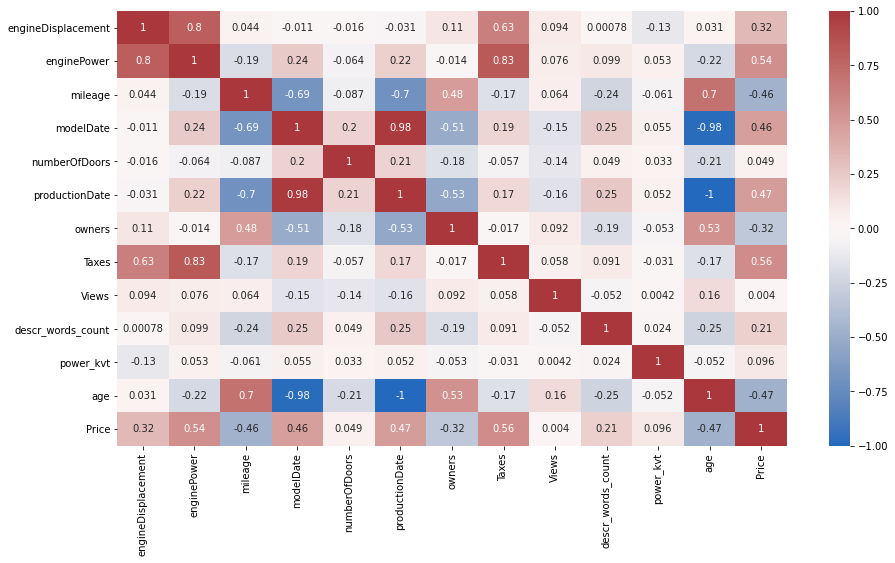

In [110]:
plt.figure(figsize=(15, 8));
sns.heatmap(df[df.train == 1][numerical + ['Price']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag');

In [111]:
features_remove = []
features_remove.append('modelDate') # highly correlated with production date

In [112]:
df = df.drop(columns=features_remove)

In [113]:
numerical.remove('modelDate')

In [114]:
binary = list(set(df.columns) - set(categorical + numerical + ['Price', 'train']))

<AxesSubplot:>

Text(0.5, 0, 'f-statistic value')

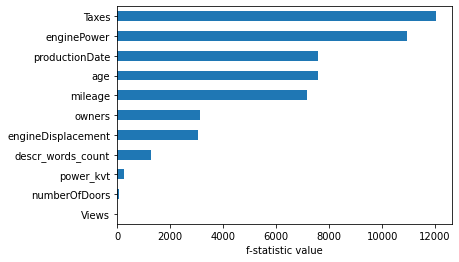

In [115]:
# importance of numerical columns
imp_num = pd.Series(f_regression(df[df.train==1][numerical], df[df.train==1]['Price'])[0], index=numerical)
imp_num.sort_values(inplace=True)
imp_num.plot(kind = 'barh')
plt.xlabel('f-statistic value')

In [118]:
# remove outliers in age
Q1 = df[df['train']==1]['age'].quantile(0.25)
Q3 = df[df['train']==1]['age'].quantile(0.75)
IQR = Q3 - Q1
df[df['train']==1] = df[df['train']==1][~((df[df['train']==1]['age'] < (Q1 - 1.5 * IQR)) |(df[df['train']==1]['age'] > (Q3 + 1.5 * IQR)))]
# df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

<AxesSubplot:title={'center':'The importance of the categorical columns.'}>

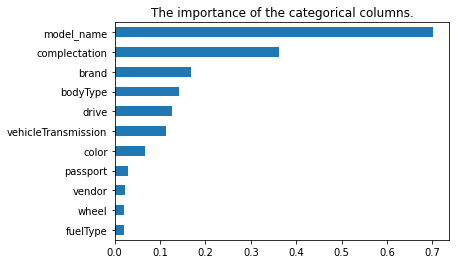

In [119]:
# let's look at the importance of the categorical and binary columns
imp_cat = pd.Series(
    mutual_info_regression(
        df[df.train == 1][list(set(df.columns) & set(categorical))], 
        df[df.train == 1]['Price'], 
        discrete_features=True), index=list(set(df.columns) & set(categorical))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='The importance of the categorical columns.')
plt.show()

## Scaler

In [120]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['train', 'Price']))
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.drop(columns=['train', 'Price']).columns)

In [121]:
df = scaled_df.join(df[['train', 'Price']])

### ML

In [122]:
X = df.query('train == 1').drop(['train', 'Price'], axis=1)
X_sub = df.query('train == 0').drop(['train', 'Price'], axis=1)

In [123]:
X_sub


,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,...,airbag-passenger,airbag-driver,electro-window-front,front-seats-heat,computer,electro-mirrors,lock,abs,complectation,age
0,-0.092664,0.648716,0.603061,-1.248593,-0.952333,-0.560089,-0.789523,0.266266,0.743707,0.504724,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,0.376113,-0.644342
1,-0.092664,0.648716,0.969632,-0.837967,-0.898462,-0.560089,-0.922837,0.266266,0.743707,0.946795,...,0.930711,0.907381,-1.106696,0.890855,0.865355,0.820598,0.712857,0.717094,0.376113,-1.096526
2,-0.092664,0.648716,0.419775,-0.632654,-0.445948,-0.560089,-0.650624,1.128661,0.743707,0.504724,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,-2.862157,-0.644342
3,-0.092664,0.648716,-0.679938,-0.837967,-0.898462,-0.560089,-0.581174,0.266266,0.743707,0.504724,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,-2.862157,-0.644342
4,-0.092664,0.648716,-1.596365,-0.632654,-0.445948,-0.560089,-0.942948,0.266266,0.743707,0.210010,...,0.930711,0.907381,-1.106696,0.890855,0.865355,0.820598,0.712857,0.717094,0.376113,-0.342886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,0.762204,-1.362304,-0.679938,-0.837967,-0.618335,-0.560089,-0.382746,-1.537435,-0.690324,0.504724,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,0.376113,-0.644342
34682,0.762204,-1.362304,0.969632,-0.427341,-0.036530,1.814080,-0.551410,-1.509252,-0.690324,1.094152,...,-1.074447,-1.102072,-1.106696,-1.122517,-1.155595,-1.218623,-1.402806,-1.394517,0.376113,-1.247255
34683,0.762204,-1.362304,0.419775,0.085942,-0.252013,-0.560089,2.047996,-1.509252,-0.690324,-2.000347,...,-1.074447,-1.102072,-1.106696,-1.122517,-1.155595,-1.218623,-1.402806,-1.394517,0.376113,1.918037
34684,-1.118506,-1.362304,-0.679938,-0.427341,-0.101175,1.814080,-0.625820,1.540130,0.743707,0.357367,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,0.514006,-0.493614


In [124]:
X_sub

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,...,airbag-passenger,airbag-driver,electro-window-front,front-seats-heat,computer,electro-mirrors,lock,abs,complectation,age
0,-0.092664,0.648716,0.603061,-1.248593,-0.952333,-0.560089,-0.789523,0.266266,0.743707,0.504724,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,0.376113,-0.644342
1,-0.092664,0.648716,0.969632,-0.837967,-0.898462,-0.560089,-0.922837,0.266266,0.743707,0.946795,...,0.930711,0.907381,-1.106696,0.890855,0.865355,0.820598,0.712857,0.717094,0.376113,-1.096526
2,-0.092664,0.648716,0.419775,-0.632654,-0.445948,-0.560089,-0.650624,1.128661,0.743707,0.504724,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,-2.862157,-0.644342
3,-0.092664,0.648716,-0.679938,-0.837967,-0.898462,-0.560089,-0.581174,0.266266,0.743707,0.504724,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,-2.862157,-0.644342
4,-0.092664,0.648716,-1.596365,-0.632654,-0.445948,-0.560089,-0.942948,0.266266,0.743707,0.210010,...,0.930711,0.907381,-1.106696,0.890855,0.865355,0.820598,0.712857,0.717094,0.376113,-0.342886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,0.762204,-1.362304,-0.679938,-0.837967,-0.618335,-0.560089,-0.382746,-1.537435,-0.690324,0.504724,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,0.376113,-0.644342
34682,0.762204,-1.362304,0.969632,-0.427341,-0.036530,1.814080,-0.551410,-1.509252,-0.690324,1.094152,...,-1.074447,-1.102072,-1.106696,-1.122517,-1.155595,-1.218623,-1.402806,-1.394517,0.376113,-1.247255
34683,0.762204,-1.362304,0.419775,0.085942,-0.252013,-0.560089,2.047996,-1.509252,-0.690324,-2.000347,...,-1.074447,-1.102072,-1.106696,-1.122517,-1.155595,-1.218623,-1.402806,-1.394517,0.376113,1.918037
34684,-1.118506,-1.362304,-0.679938,-0.427341,-0.101175,1.814080,-0.625820,1.540130,0.743707,0.357367,...,0.930711,0.907381,0.903591,0.890855,0.865355,0.820598,0.712857,0.717094,0.514006,-0.493614


In [125]:
y = df[df['train']==1]['Price']

## Train Split

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по mileage. 
C ней будем сравнивать другие модели.




In [127]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [128]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['mileage'].map(tmp_train.groupby('mileage')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")
# Точность наивной модели по метрике MAPE: 63.43%

Точность наивной модели по метрике MAPE: 63.43%


# Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [129]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, y_train,
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_single_model_baseline.model')

In [130]:
# оцениваем точность
# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
# Точность модели по метрике MAPE: 15.20%

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [131]:
# np.log(y_train)

In [132]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_single_model_2_baseline.model')

In [133]:
# predict_test = np.exp(model.predict(X_test))
# predict_submission = np.exp(model.predict(X_sub))

In [134]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")
# Точность модели по метрике MAPE: 13.06%

# Model 3 : Random Forest

In [146]:
# rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# rf.fit(X_train, y_train)
# predict_rf = rf.predict(X_test)
# print(f"The MAPE mertics of the Random Forest without log: {(mape(y_test, predict_rf) * 100):0.2f}%.")
# The MAPE mertics of the Random Forest without log: 16.64%.

# with log-transformation of the target variable
rf_log = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rf_log.fit(X_train, np.log(y_train))
predict_rf_log = np.exp(rf_log.predict(X_test))
# 46.93916 LB
# print(f"The MAPE mertic for the Random Forest with log: {(mape(y_test, predict_rf_log) * 100):0.2f}%.")
# The MAPE mertic for the Random Forest with log: 15.26%.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.3s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


# Model 4 : LogisticRegression

In [136]:
# logistic = LogisticRegression(solver='saga', tol=0.1, penalty='l2', random_state=RANDOM_SEED, n_jobs=-1)
# logistic.fit(X_train, y_train)
# predict_log = logistic.predict(X_test)
# print(f"The MAPE mertics of the Logistic Regression without log: {(mape(y_test, predict_log) * 100):0.2f}%.")
# The MAPE mertics of the Logistic Regression without log: 39.27%.

# Model 5 :  Support Vector Machine (SVM)

In [137]:
# svr = svm.SVR()
# svr.fit(X_train, np.log(y_train))
# print(f"The MAPE mertics of the SVR: {(mape(y_test, np.exp(svr.predict(X_test))) * 100):0.2f}%.")
# The MAPE mertics of the SVR: 19.70%.

# Model 6 : ExtraTreeRegressor

In [138]:
# with log-transformation of the target variable
etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
etr_log.fit(X_train, np.log(y_train))
etr_pred = np.exp(etr_log.predict(X_test))
print(f"The MAPE mertic for the ExtraTreesRegressor: {(mape(y_test, etr_pred) * 100):0.2f}%.")
# The MAPE mertic for the ExtraTreesRegressor: 15.37%.
# 50.52248 LB

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.4s finished


ExtraTreesRegressor(n_jobs=-1, random_state=42, verbose=1)

The MAPE mertic for the ExtraTreesRegressor: 15.37%.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


# Model 6 : XGBoostRegressor

In [143]:
xgb_log = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.5,               
    learning_rate=0.05, 
    max_depth=12, 
    alpha=1,                   
    n_estimators=1000,
    random_state=RANDOM_SEED,
    verbose=1, 
    n_jobs=-1,
)

xgb_log.fit(X_train, np.log(y_train))
y_pred = np.exp(xgb_log.predict(X_test))

print(f"The MAPE mertic for the XGBoost: {(mape(y_test, y_pred) * 100):0.2f}%.")
# The MAPE mertic for the XGBoost: 13.31%. 
# 36.33779 LB

[21:15:09] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbose=1,
             verbosity=None)

The MAPE mertic for the XGBoost: 13.31%.


# Model 7 : StackingRegressor

In [140]:
# estimators = [
#     ('cat', CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
# #                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )),
    
#     ('xgb', xgb.XGBRegressor(objective='reg:squarederror', 
#                              colsample_bytree=0.5, 
#                              learning_rate=0.05, 
#                              max_depth=12, 
#                              alpha=1, 
#                              n_jobs=-1, 
#                              n_estimators=1000, 
#                              random_state=RANDOM_SEED))
# ]

# sr_log = StackingRegressor(
#     estimators=estimators,
#     final_estimator=LinearRegression()
# )

# sr_log.fit(X_train, np.log(y_train))
# y_pred = np.exp(sr_log.predict(X_test))

# print(f"The MAPE mertic for the default StackingRegressor: {(mape(y_test, y_pred) * 100):0.2f}%.")
# The MAPE mertic for the default StackingRegressor: 12.96%.
# 56.76500 LB

StackingRegressor(estimators=[('cat',
                               <catboost.core.CatBoostRegressor object at 0x7efd101874d0>),
                              ('xgb',
                               XGBRegressor(alpha=1, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05,
                                            max_delta_step=None, max_depth=12,
                                            min_child_weight=None, missing=nan,
 

The MAPE mertic for the default StackingRegressor: 12.96%.


# Submission

In [147]:
predict_submission = np.exp(xgb_log.predict(X_sub))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_xgb.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


,sell_id,price
0,1100575026,9.711879e+05
1,1100549428,1.489553e+06
2,1100658222,1.604374e+06
3,1100937408,1.171446e+06
4,1101037972,7.618852e+05
5,1100912634,8.176393e+05
6,1101228730,7.713010e+05
7,1100165896,6.512224e+05
8,1100768262,2.552039e+06
9,1101218501,7.694850e+05
